# 1. Cài đặt các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
!pip install xgboost
import xgboost as xgb
import warnings
warnings.simplefilter('ignore', FutureWarning)

# 2. Tải bộ dữ liệu

In [2]:
df01 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_april.csv')
df02 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_october.csv')

# Ghép 2 file lại với nhau
data_filled = pd.concat([df01, df02], ignore_index=True)

# 3. Chia train test theo thời gian

In [3]:
def split_data_by_multiple_ranges(df, train_ranges):
    train_mask = False
    for start, end in train_ranges:
        train_mask |= (df['datetime'] >= start) & (df['datetime'] < end)
    train_df = df[train_mask]
    test_df = df[~train_mask]
    return train_df, test_df

def convert_rain_label(df):
    df['AWS'] = df['AWS'].apply(lambda x: 1 if x > 0 else 0)
    return df

# Gắn nhãn
df_all1 = convert_rain_label(data_filled)

# Chuyển datetime nếu chưa
df_all1['datetime'] = pd.to_datetime(df_all1['datetime'])

# Chọn các khoảng train: tháng 4/2019, 10/2019, 4/2020
train_ranges = [
    ("2019-04-01", "2019-04-30"),
    ("2019-10-01", "2019-10-31"),
    ("2020-04-01", "2020-04-30"),
]

# Tách train/test theo mốc trên
train_df, test_df = split_data_by_multiple_ranges(df_all1, train_ranges)

# Giữ lại chỉ test tháng 10/2020
test_df = test_df[
    (test_df['datetime'] >= "2020-10-01") & (test_df['datetime'] <= "2020-10-31")
]

# Kết quả
print(f"Train set: {train_df.shape}")
print(f"Test set (October 2020): {test_df.shape}")

Train set: (428242, 33)
Test set (October 2020): (207094, 33)


In [4]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

# 4. Chuẩn hóa dữ liệu

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 5. Chọn đặc trưng

'B09B', 'B10B', 'B11B', 'B12B', 'B14B', 'B16B', 'I2B', 'I4B', 'IRB', 'WVB' tương quan với nhau cao

=> Chọn 'B10B', 'B14B', 'I2B' làm đại diện

'TCW' và 'TCWV' gần như nhau => Chọn TCWV

Ta có feature như sau:

In [6]:
feature_names = ['CAPE', 'EWSS', 'IE', 'ISOR','KX', 'PEV', 'R250', 'R500', 'R850', 
                    'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCWV', 'U250', 'U850', 'V250', 
                    'V850', 'B10B', 'B14B', 'I2B']

In [7]:
X_train1 = X_train_scaled[feature_names]
X_test1 = X_test_scaled[feature_names]

## 5.1 Dùng Random Forest

### 5.1.1 Method 1: Built-in feature importance with Scikit Learn

In [8]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train1, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Built-in feature importance (Gini Importance)
importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

   Feature  Gini Importance
19    B14B         0.113275
20     I2B         0.105078
18    B10B         0.089749
12    TCLW         0.071287
8     R850         0.060663
15    U850         0.048687
14    U250         0.045581
7     R500         0.043330
17    V850         0.040606
16    V250         0.040304
0     CAPE         0.039180
6     R250         0.039171
13    TCWV         0.034237
4       KX         0.033259
1     EWSS         0.031449
5      PEV         0.030390
2       IE         0.030340
11    SSHF         0.029621
9     SLHF         0.028034
10    SLOR         0.024046
3     ISOR         0.021713


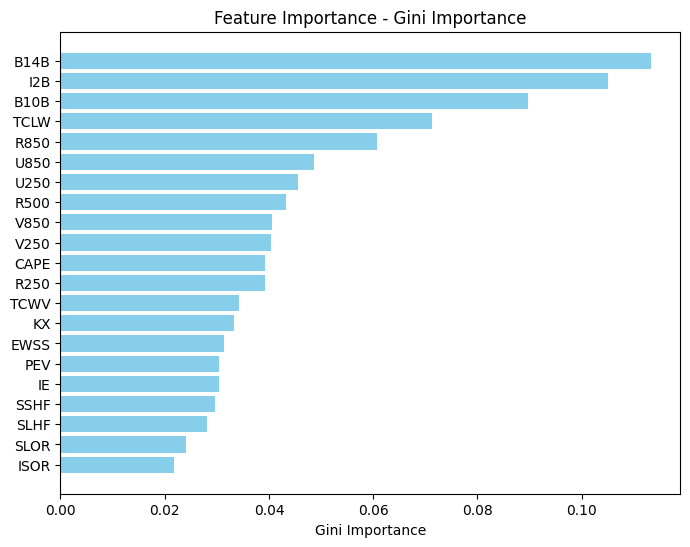

In [10]:
# Sắp xếp 'importances' theo thứ tự giảm dần và sắp xếp lại 'feature_names' tương ứng
sorted_indices = np.argsort(importances)[::-1]  # Sắp xếp giảm dần
sorted_importances = np.array(importances)[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Tạo biểu đồ thanh
plt.figure(figsize=(8, 6))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Đảo ngược trục y để phần tử quan trọng nhất lên đầu
plt.show()

In [11]:
# Độ chính xác ban đầu
initial_accuracy = accuracy_score(y_test, clf.predict(X_test1))

# Tính MDA
importances = []
X_test_array = X_test1.to_numpy()
for i in range(X_test_array.shape[1]):
    X_test_copy = X_test_array.copy()
    np.random.shuffle(X_test_copy[:, i])  # Shuffle cột i
    shuff_accuracy = accuracy_score(y_test, clf.predict(X_test_copy))
    importances.append(initial_accuracy - shuff_accuracy)

# Tạo DataFrame kết quả
accuracy_df = pd.DataFrame({
    'Feature': feature_names,
    'Decrease in Accuracy': importances
}).sort_values('Decrease in Accuracy', ascending=False)

# In kết quả
print(accuracy_df)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X

   Feature  Decrease in Accuracy
19    B14B              0.014911
20     I2B              0.013791
7     R500              0.012555
18    B10B              0.008035
8     R850              0.007765
0     CAPE              0.006789
12    TCLW              0.006070
5      PEV              0.004747
10    SLOR              0.004153
13    TCWV              0.002685
11    SSHF              0.001845
3     ISOR              0.001608
2       IE              0.001424
15    U850              0.001410
9     SLHF              0.001144
6     R250              0.000985
4       KX              0.000917
16    V250             -0.000367
17    V850             -0.000811
14    U250             -0.002830
1     EWSS             -0.003124


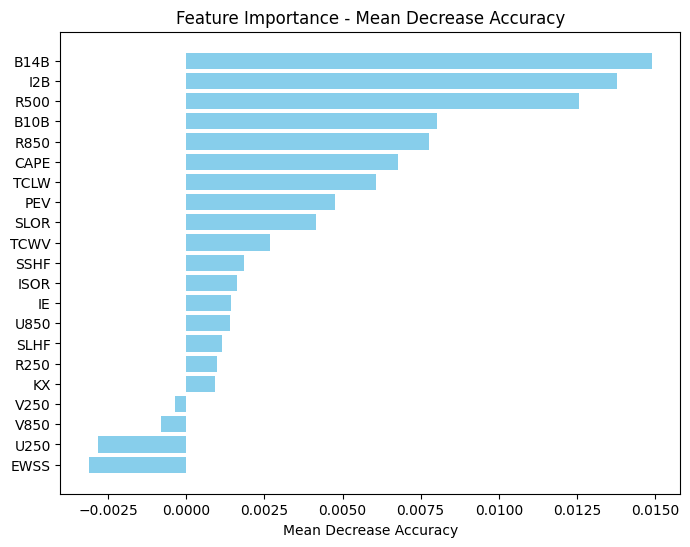

In [12]:
# Giả sử 'feature_names' và 'importances' là các mảng hoặc danh sách có sẵn
# Sắp xếp 'importances' theo thứ tự giảm dần và sắp xếp lại 'feature_names' tương ứng
sorted_indices = np.argsort(importances)[::-1]  # Sắp xếp giảm dần
sorted_importances = np.array(importances)[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Tạo biểu đồ thanh
plt.figure(figsize=(8, 6))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Mean Decrease Accuracy')
plt.title('Feature Importance - Mean Decrease Accuracy')
plt.gca().invert_yaxis()  # Đảo ngược trục y để phần tử quan trọng nhất lên đầu
plt.show()

### 5.1.2 Method 2: Permutation feature importance

In [13]:
# Permutation feature importance
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_test1, y_test, n_repeats=10, random_state=0, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)
print(perm_imp_df)

   Feature  Permutation Importance
19    B14B                0.015453
20     I2B                0.013551
7     R500                0.012519
18    B10B                0.007737
8     R850                0.007375
0     CAPE                0.006908
12    TCLW                0.006503
5      PEV                0.004995
10    SLOR                0.004648
13    TCWV                0.002609
15    U850                0.001715
3     ISOR                0.001644
2       IE                0.001552
4       KX                0.001416
11    SSHF                0.001364
6     R250                0.001279
9     SLHF                0.001057
16    V250                0.000031
17    V850               -0.000622
1     EWSS               -0.003011
14    U250               -0.003052


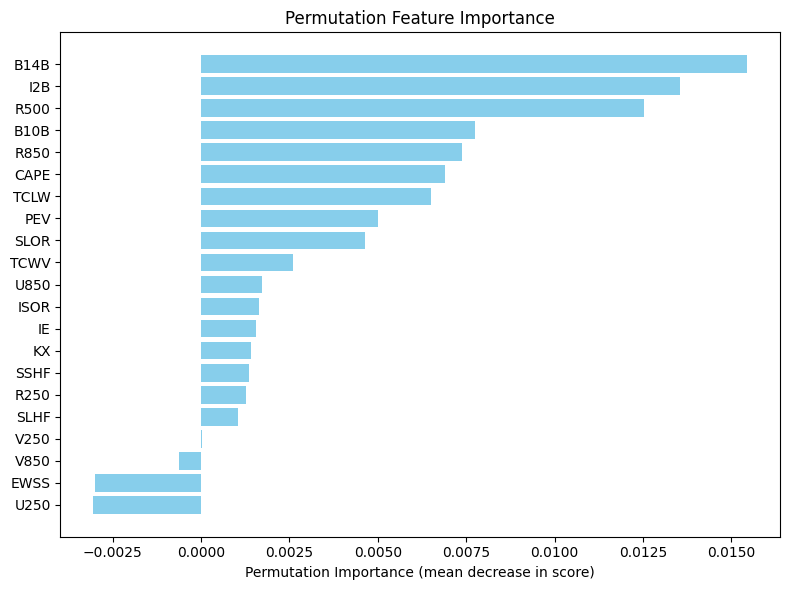

In [14]:
# Vẽ biểu đồ thanh
plt.figure(figsize=(8, 6))
plt.barh(perm_imp_df['Feature'], perm_imp_df['Permutation Importance'], color='skyblue')
plt.xlabel('Permutation Importance (mean decrease in score)')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()  # Đảo ngược trục Y để feature quan trọng nhất ở trên cùng
plt.tight_layout()
plt.show()

## 5.2 Dùng XGBoost

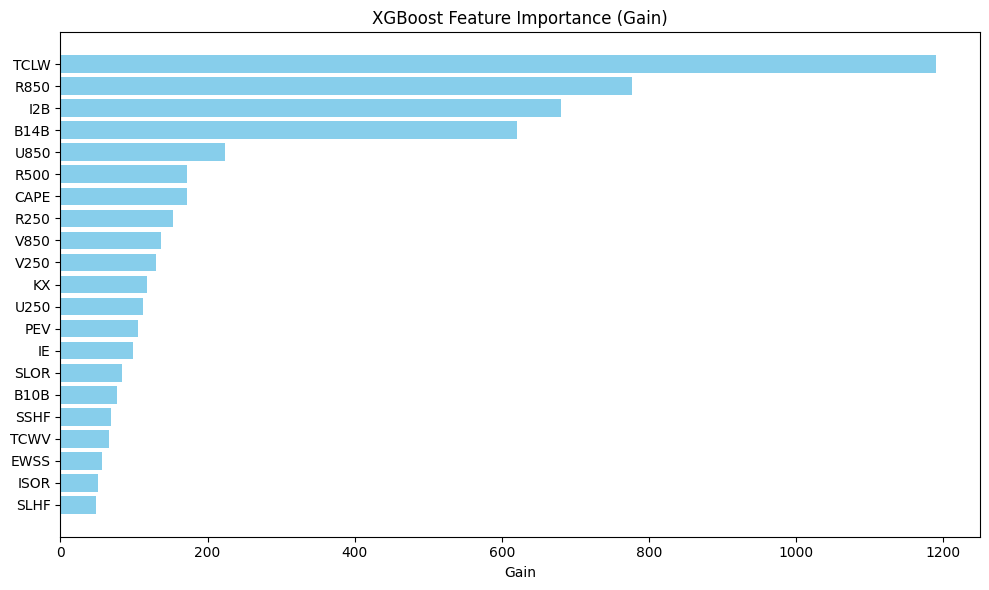

In [15]:
import xgboost as xgb

# Train XGBoost model
dtrain = xgb.DMatrix(X_train1, label=y_train)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42
}
bst = xgb.train(params, dtrain, num_boost_round=100)

# Lấy importance theo gain
importance_dict = bst.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
}).sort_values('Gain', ascending=True)

# Vẽ bar plot đẹp
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Gain'], color='skyblue')
plt.xlabel('Gain')
plt.title('XGBoost Feature Importance (Gain)')
plt.tight_layout()
plt.show()

## 5.3 Dùng LightGBM

In [16]:
import lightgbm as lgb

# Creating the dataframe 
# train_data = lgb.Dataset(X_train_april_scaled, label = y_train_april)
train_data = lgb.Dataset(X_train1, label = y_train)


# Define parameters for the model
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "learning_rate" : 0.1
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=5)

[LightGBM] [Info] Number of positive: 34748, number of negative: 393494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5031
[LightGBM] [Info] Number of data points in the train set: 428242, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081141 -> initscore=-2.426944
[LightGBM] [Info] Start training from score -2.426944


In [17]:
# Lấy importance theo gain
importance = model.feature_importance(importance_type='gain')

# Tạo DataFrame và sắp xếp theo Gain
importance_df = pd.DataFrame({
    'Feature': feature_names,  # Tên các đặc trưng
    'Gain': importance  # Mức độ quan trọng của từng đặc trưng
}).sort_values('Gain', ascending=False)  # Sắp xếp theo Gain từ cao đến thấp

# In ra bảng importance
print("Feature Importance (Gain) in LightGBM:")
print(importance_df)

Feature Importance (Gain) in LightGBM:
   Feature          Gain
12    TCLW  95593.951355
19    B14B  57151.676376
8     R850  17829.901520
15    U850  10024.207916
20     I2B   9404.023254
7     R500   8694.895996
14    U250   7283.025009
0     CAPE   5383.166916
17    V850   4998.371033
16    V250   4860.774963
6     R250   4135.285980
5      PEV   1662.240021
4       KX   1474.538025
10    SLOR   1114.832977
1     EWSS    775.826996
18    B10B    651.483002
2       IE    363.856995
11    SSHF    305.407013
13    TCWV    290.878998
9     SLHF      0.000000
3     ISOR      0.000000


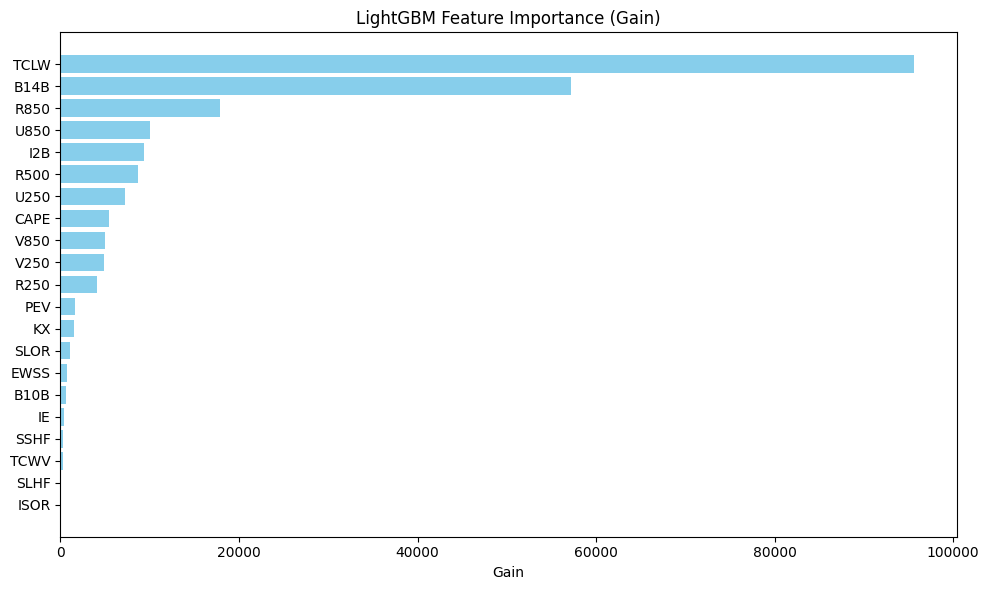

In [18]:
importance = model.feature_importance(importance_type='gain')

# Tạo DataFrame và sắp xếp
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gain': importance
}).sort_values('Gain', ascending=True)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Gain'], color='skyblue')
plt.xlabel('Gain')
plt.title('LightGBM Feature Importance (Gain)')
plt.tight_layout()
plt.show()

In [19]:
# Lấy importance theo gain
importance = model.feature_importance(importance_type='split')

# Tạo DataFrame và sắp xếp theo Gain
importance_df = pd.DataFrame({
    'Feature': feature_names,  
    'Split': importance  
}).sort_values('Split', ascending=False)  # Sắp xếp theo Gain từ cao đến thấp

# In ra bảng importance
print("Feature Importance (Split) in LightGBM:")
print(importance_df)

Feature Importance (Split) in LightGBM:
   Feature  Split
19    B14B     22
12    TCLW     17
14    U250     17
15    U850     13
7     R500     12
16    V250     10
0     CAPE      9
6     R250      9
8     R850      9
17    V850      8
20     I2B      7
1     EWSS      3
5      PEV      3
4       KX      3
10    SLOR      3
18    B10B      2
11    SSHF      1
13    TCWV      1
2       IE      1
9     SLHF      0
3     ISOR      0


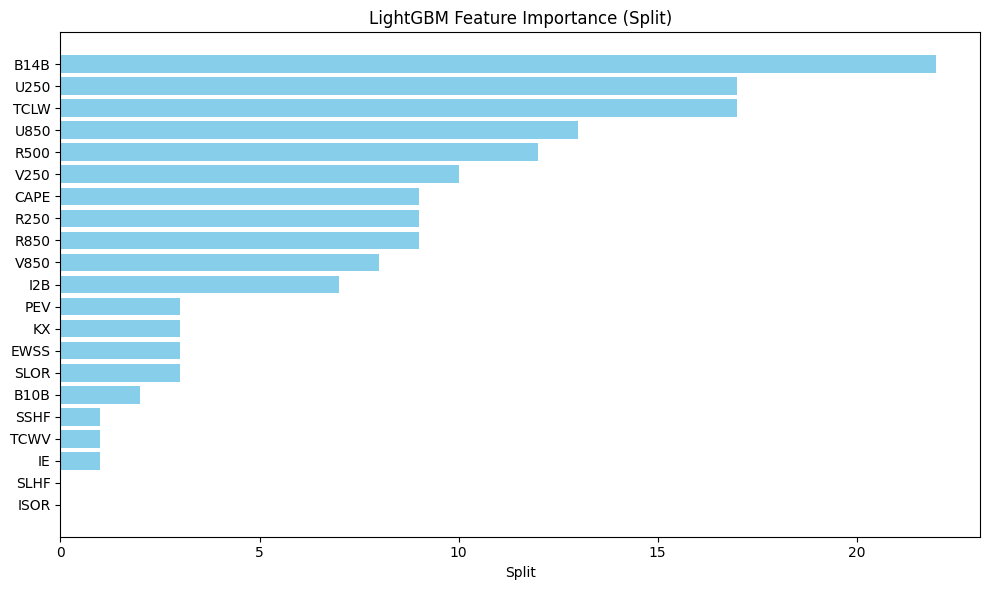

In [20]:
importance = model.feature_importance(importance_type='split')

# Tạo DataFrame và sắp xếp
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Split': importance
}).sort_values('Split', ascending=True)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Split'], color='skyblue')
plt.xlabel('Split')
plt.title('LightGBM Feature Importance (Split)')
plt.tight_layout()
plt.show()

## 5.4 Voting


🎯 Voting Feature Importance Ranking:
   Feature  Voting Rank
1     B14B     1.666667
4      I2B     4.166667
15    TCLW     4.250000
10    R500     4.333333
11    R850     4.666667
2     CAPE     6.833333
18    U850     8.666667
0     B10B    10.000000
8      PEV    10.416667
13    SLOR    11.583333
9     R250    12.500000
19    V250    13.333333
17    U250    13.750000
16    TCWV    14.166667
20    V850    14.166667
7       KX    14.250000
5       IE    14.666667
14    SSHF    15.000000
6     ISOR    16.166667
12    SLHF    18.166667
3     EWSS    18.250000


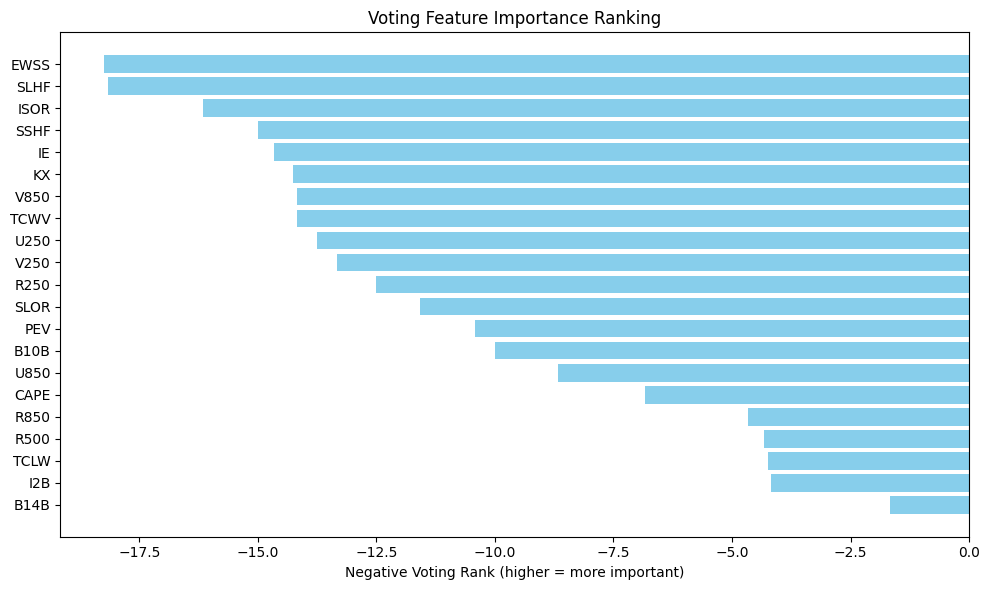

In [21]:
# Bước 1: Gộp tất cả các bảng importance đã tính
importance_frames = []

# Gini importance
gini_df = pd.DataFrame({'Feature': feature_names, 'Score': importances})
gini_df['Method'] = 'Gini'
importance_frames.append(gini_df)

# MDA
mda_df = accuracy_df[['Feature', 'Decrease in Accuracy']].copy()
mda_df.columns = ['Feature', 'Score']

mda_df['Method'] = 'MDA'
importance_frames.append(mda_df)

# Permutation importance
perm_df = pd.DataFrame({'Feature': feature_names, 'Score': result.importances_mean})
perm_df['Method'] = 'Permutation'
importance_frames.append(perm_df)

# XGBoost Gain
xgb_gain_df = pd.DataFrame({'Feature': list(importance_dict.keys()), 'Score': list(importance_dict.values())})

xgb_gain_df['Method'] = 'XGB_Gain'
importance_frames.append(xgb_gain_df)

# LightGBM Gain
lgb_gain_df = pd.DataFrame({'Feature': feature_names, 'Score': model.feature_importance(importance_type='gain')})
lgb_gain_df['Method'] = 'LGB_Gain'
importance_frames.append(lgb_gain_df)

# LightGBM Split
lgb_split_df = pd.DataFrame({'Feature': feature_names, 'Score': model.feature_importance(importance_type='split')})
lgb_split_df['Method'] = 'LGB_Split'
importance_frames.append(lgb_split_df)

# Bước 2: Chuẩn hóa lại ranking từ mỗi phương pháp
importance_all = pd.concat(importance_frames)

# Ranking: Giá trị càng cao thì hạng càng thấp (descending)
importance_all['Rank'] = importance_all.groupby('Method')['Score'].rank(ascending=False)

# Bước 3: Tính voting (trung bình thứ hạng)
voting_df = importance_all.groupby('Feature')['Rank'].mean().reset_index()
voting_df.columns = ['Feature', 'Voting Rank']
voting_df = voting_df.sort_values('Voting Rank')

# Bước 4: In bảng kết quả
print("\n🎯 Voting Feature Importance Ranking:")
print(voting_df)

# Bước 5: Vẽ biểu đồ Voting
plt.figure(figsize=(10, 6))
plt.barh(voting_df['Feature'], -voting_df['Voting Rank'], color='skyblue')  # Dùng dấu trừ để quan trọng nhất ở trên
plt.xlabel('Negative Voting Rank (higher = more important)')
plt.title('Voting Feature Importance Ranking')
plt.tight_layout()
plt.show()

In [22]:
top_features = voting_df.head(15)['Feature'].tolist()
print("Top 10 voted features:", top_features)

Top 10 voted features: ['B14B', 'I2B', 'TCLW', 'R500', 'R850', 'CAPE', 'U850', 'B10B', 'PEV', 'SLOR', 'R250', 'V250', 'U250', 'TCWV', 'V850']
